In [54]:
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations


class Problem(object):
   """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When yiou create an instance of a subclass, specify `initial`, and `goal` states
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

   def __init__(self, initial=None, goal=None, **kwds):
        self.__dict__.update(initial=initial, goal=goal, **kwds)

   def actions(self, state):        raise NotImplementedError
   def result(self, state, action): raise NotImplementedError
   def is_goal(self, state):        return state == self.goal
   def action_cost(self, s, a, s1): return 1
   def h(self, node):               return 0

   def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)


class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost


failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.


def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)
        yield Node(s1, node, action, cost)


def path_actions(node):
    "The sequence of actions to get to this node."
    if node.parent is None:
        return []
    return path_actions(node.parent) + [node.action]


def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None):
        return []
    return path_states(node.parent) + [node.state]


################################################################################
"""Queues-First-in-first-out and Last-in-first-out queues, and a PriorityQueue,
which allows you to keep a collection of items, and continually remove from it
the item with minimum f(item) score."""
################################################################################

FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x):
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)

    def add(self, item):
        """Add item to the queuez."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]

    def top(self): return self.items[0][1]

    def __len__(self): return len(self.items)

################################################################################
""" Search Algorithms: Best-First Best-first search with various f(n) functions
gives us different search algorithms. Note that A*, weighted A* and greedy
search can be given a heuristic function, h, but if h is not supplied they use
the problem's default h function (if the problem does not define one, it is taken
as h(n) = 0). """
################################################################################

def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure


def best_first_tree_search(problem, f):
    "A version of best_first_search without the `reached` table."
    frontier = PriorityQueue([Node(problem.initial)], key=f)
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            if not is_cycle(child):
                frontier.add(child)
    return failure


def g(n): return n.path_cost


def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + h(n))


def astar_tree_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n), with no `reached` table."""
    h = h or problem.h
    return best_first_tree_search(problem, f=lambda n: g(n) + h(n))


def weighted_astar_search(problem, h=None, weight=1.4):
    """Search nodes with minimum f(n) = g(n) + weight * h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + weight * h(n))


def greedy_bfs(problem, h=None):
    """Search nodes with minimum h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=h)


def uniform_cost_search(problem):
    "Search nodes with minimum path cost first."
    return best_first_search(problem, f=g)


def breadth_first_bfs(problem):
    "Search shallowest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=len)


def depth_first_bfs(problem):
    "Search deepest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=lambda n: -len(n))


def is_cycle(node, k=30):
    "Does this node form a cycle of length k or less?"
    def find_cycle(ancestor, k):
        return (ancestor is not None and k > 0 and
                (ancestor.state == node.state or find_cycle(ancestor.parent, k - 1)))
    return find_cycle(node.parent, k)

################################################################################
""" Other Search Algorithms Here are the other search algorithms: """
################################################################################

def breadth_first_search(problem):
    "Search shallowest nodes in the search tree first."
    node = Node(problem.initial)
    if problem.is_goal(problem.initial):
        return node
    frontier = FIFOQueue([node])
    reached = {problem.initial}
    while frontier:
        node = frontier.pop()
        for child in expand(problem, node):
            s = child.state
            if problem.is_goal(s):
                return child
            if s not in reached:
                reached.add(s)
                frontier.appendleft(child)
    return failure


def iterative_deepening_search(problem):
    "Do depth-limited search with increasing depth limits."
    for limit in range(1, sys.maxsize):
        result = depth_limited_search(problem, limit)
        if result != cutoff:
            return result


def depth_limited_search(problem, limit=10):
    "Search deepest nodes in the search tree first."
    frontier = LIFOQueue([Node(problem.initial)])
    result = failure
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        elif len(node) >= limit:
            result = cutoff
        elif not is_cycle(node):
            for child in expand(problem, node):
                frontier.append(child)
    return result


def depth_first_recursive_search(problem, node=None):
    if node is None:
        node = Node(problem.initial)
    if problem.is_goal(node.state):
        return node
    elif is_cycle(node):
        return failure
    else:
        for child in expand(problem, node):
            result = depth_first_recursive_search(problem, child)
            if result:
                return result
        return failure

################################################################################
""" Reporting Summary Statistics on Search Algorithms Now let's gather some
metrics on how well each algorithm does. We'll use CountCalls to wrap a Problem
object in such a way that calls to its methods are delegated to the original
problem, but each call increments a counter. Once we've solved the problem,
we print out summary statistics.  """
################################################################################

class CountCalls:
    """Delegate all attribute gets to the object, and count them in ._counts"""
    def __init__(self, obj):
        self._object = obj
        self._counts = Counter()

    def __getattr__(self, attr):
        "Delegate to the original object, after incrementing a counter."
        self._counts[attr] += 1
        return getattr(self._object, attr)


def report(searchers, problems, verbose=True):
    """Show summary statistics for each searcher (and on each problem unless verbose is false)."""
    for searcher in searchers:
        print(searcher.__name__ + ':')
        total_counts = Counter()
        for p in problems:
            prob   = CountCalls(p)
            soln   = searcher(prob)
            counts = prob._counts;
            counts.update(actions=len(soln), cost=soln.path_cost)
            total_counts += counts
            if verbose: report_counts(counts, str(p)[:40])
        report_counts(total_counts, 'TOTAL\n')

def report_counts(counts, name):
    """Print one line of the counts report."""
    print('{:9,d} nodes |{:9,d} goal |{:5.0f} cost |{:8,d} actions | {}'.format(
          counts['result'], counts['is_goal'], counts['cost'], counts['actions'], name))

#  ***Star puzzle***



---



The task involves solving the StarPuzzle, which is centered around arranging the first twelve positive numbers, 1 to 12, onto a unique 'STAR' shaped grid. The grid is designed in such a way that specific sums of numbers along various paths must equate to each other. These sums are carefully structured and include combinations of adjacent, diagonal, and intersecting numbers.



The main goal of this task is to find a valid arrangement of numbers on the grid that satisfies the given sum equations in the StarPuzzle. To achieve this, we'll employ two search algorithms: Breadth-First Search (BFS) and A*. The methods and techniques used by both algorithms will be explained . It will showcase the final number arrangements that meet the criteria for each algorithm. Additionally, observations made during the puzzle-solving process will be explained, helping to explain the math and logic behind the solutions.


Also,one crucial aspect of this Task is the comparison between BFS and A*, allowing us to determine which algorithm performs better in solving the StarPuzzle.

This is the shape of Star Puzzle that shows a Hexagram shape as it is shown in figure 1 :

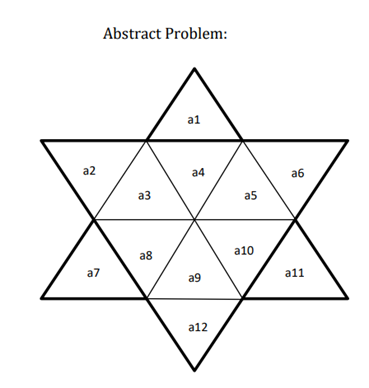

In Figure 2, it explains and shows the paths in the shape that their sums should equate each others, where the sums of numbers are :

*   Sum 1 = a1+a4+a3+a8+a7
*   Sum 2 = a1+a4+a5+a10+a11
*   Sum 3 = a7+a8+a9+a10+a11
*   Sum 4 = a2+a3+a4+a5+a6
*   Sum 5 = a2+a3+a8+a9+a12
*   Sum 6 = a12+a9+a10+a5+a6

Where Sum 1 = Sum 2 = Sum 3 = Sum 4 = Sum 5 = Sum 6

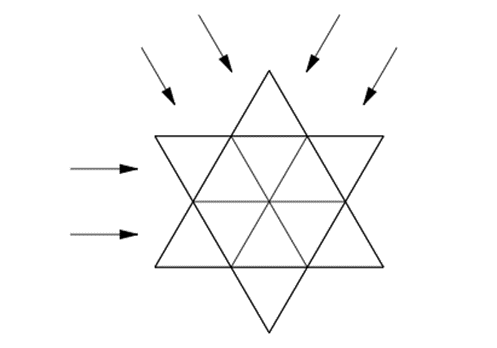

In figure 3, it shows one possible way of the numbers arranged in the paths of the Star shaped puzzle where each paths equate to the other by the value of 33

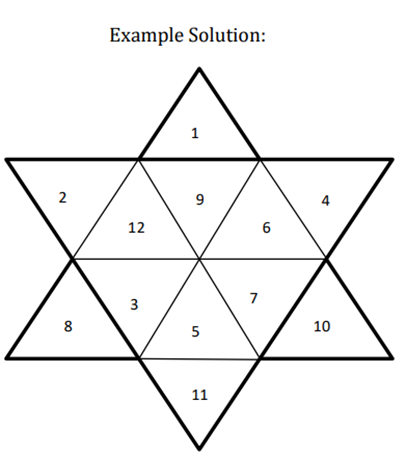

In [55]:
# Define a class  StarPuzzle that inherits from a 'Problem' class
class StarPuzzle(Problem):
    """
   The state is represented as 12-element tuple , starting from 1 till 12 ,
   Distributed around two equilateral triangles . where the sets that represents
   the paths of the first triangle are :

   Sum 1 = a1+a4+a3+a8+a7
   Sum 2 = a1+a4+a5+a10+a11
   Sum 3 = a7+a8+a9+a10+a11

   the second triangle are :

   Sum 4 = a2+a3+a4+a5+a6
   Sum 5 = a2+a3+a8+a9+a12
   Sum 6 = a12+a9+a10+a5+a6

   Where Sum 1 = Sum 2 = Sum 3 = Sum 4 = Sum 5 = Sum 6

   The goal is arranging the numbers from 1 till 12 in the 6 sets to satisfy the
   condition of the puzzle

                           /1\
                     --------------
                      \2/12\9/6\4/
                       -----------    -------> The goal (1, 2, 12, 9, 6, 4, 8, 3, 5, 7, 10, 11)
                       /8\3/5\7/10\
                      --------------
                          \11/

   Sum 1 = a1+a4+a3+a8+a7   = 1+9+12+3+8 = 33
   Sum 2 = a1+a4+a5+a10+a11 = 1+9+6+7+10 = 33
   Sum 3 = a7+a8+a9+a10+a11 = 8+3+5+7+10 = 33

   the second triangle are :

   Sum 4 = a2+a3+a4+a5+a6   = 2+12+9+6+4  = 33
   Sum 5 = a2+a3+a8+a9+a12  = 2+12+3+5+11 = 33
   Sum 6 = a12+a9+a10+a5+a6 = 11+5+7+6+4  = 33

    """

   # Constructor: Initialize the puzzle with an initial state and  goal dictionary

    def __init__(self, initial, goal=(1, 2, 12, 9, 6, 4, 8, 3, 5, 7, 10, 11)):
              self.initial, self.goal = initial, goal

################################################################################


    def actions(self, state):
        missing_values = []
        for i in range(1, 13):
            if i not in state:
                missing_values.append(i)
        return missing_values

################################################################################

    def result(self, state, action):
        s = list(state)
        blank = state.index(0)
        s[blank] = action
        return tuple(s)

################################################################################

    def is_goal(self,state):
        # Goal: (1,2,12,9,6,4,8,3,5,7,10,11)

      Sum_1 = sum([state[0], state[3], state[2], state[6], state[7]])
      Sum_2 = sum([state[0], state[3], state[4], state[9], state[10]])
      Sum_3 = sum([state[6], state[7], state[8], state[9], state[10]])
      Sum_4 = sum([state[1], state[2], state[3], state[4], state[5]])
      Sum_5 = sum([state[1], state[2], state[7], state[8], state[11]])
      Sum_6 = sum([state[11], state[8], state[9], state[4], state[5]])

      print(Sum_1, Sum_2, Sum_3, Sum_4, Sum_5, Sum_6)
      return Sum_1 == Sum_2 == Sum_3 == Sum_4 == Sum_5 == Sum_6

################################################################################

    def h1(self, node):
        """The misplaced tiles heuristic."""
        return hamming_distance(node.state, self.goal)

################################################################################


    def h(self, node):
        """The Manhattan heuristic."""
        X = (0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2)
        Y = (0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3)

        return sum(abs(X[s-1] - X[g-1]) + abs(Y[s-1] - Y[g-1])
                   for (s, g) in zip(node.state, self.goal) if s != 0)

################################################################################

def hamming_distance(A, B):
       "Number of positions where vectors A and B are different."
       return sum(a != b for a, b in zip(A, B))

################################################################################


def board_12(board, fmt=(5 * '{} {} {} {} {}\n')):
    # Print a star shape with 12 integers

    print("       /{}\    ".format(board[0]))
    print("    --------  ")
    print("  \{}/{}\{}/{}\{}/  ".format(board[1], board[2], board[3], board[4], board[5]))
    print("   ------------  ")
    print("  \{}/{}\{}/{}\{}/  ".format(board[6], board[7], board[8], board[9], board[10]))
    print("   ------------  ")
    print("       \{}/  ".format(board[11]))
    print("\n")


################################################################################

class Board(defaultdict):

      empty = '.'
      off = '#'
      def __init__(self, board=None, width=8, height=8, to_move=None, **kwds):
        if board is not None:
            self.update(board)
            self.width, self.height = (board.width, board.height)
        else:
            self.width, self.height = (width, height)
        self.to_move = to_move

      def __missing__(self, key):
        x, y = key
        if x < 0 or x >= self.width or y < 0 or y >= self.height:
            return self.off
        else:
            return self.empty

      def __repr__(self):
        def row(y): return ' '.join(self[x, y] for x in range(self.width))
        return '\n'.join(row(y) for y in range(self.height))

      def __hash__(self):
        return hash(tuple(sorted(self.items()))) + hash(self.to_move)

################################################################################

# **Code Explanations :**

    This 'actions' function takes a 'state' as input, representing a list of values,
    and returns a list of missing values from the range of 1 to 12. It iterates
    through numbers from 1 to 12, checks if each number is not in the 'state' list,
    and appends it to the 'missing_values' list if it's missing. Finally, it returns
    the list of missing values.
    

    def actions(self, state):
        missing_values = []
        for i in range(1, 13):
            if i not in state:
                missing_values.append(i)
        return missing_values



---


    The 'result' function takes a 'state' and an 'action' as inputs and returns
    the resulting state after applying the action. The function first converts
    the 'state' from a tuple to a list to allow modification. It finds the
    index of the blank (0) in the 'state' to identify the position where the
    action should be applied. Then, it updates the 'blank' position in the list
    with the 'action' value. Finally, it converts the modified list back to a
    tuple and returns the resulting state.
  
    def result(self, state, action):
        s = list(state)
        blank = state.index(0)
        s[blank] = action
        return tuple(s)



---


    The 'is_goal' function checks whether a given 'state' represents the goal
    state for the StarPuzzle. The goal state is defined as (1,2,12,9,6,4,8,3,5,7,10,11).
    To determine if 'state' is the goal state, the function calculates six sums (Sum_1 to Sum_6)
    based on the values at specific positions in 'state'. These sums represent
    different paths along the StarPuzzle grid. The function then prints the values
    of these sums for debugging purposes. Finally, it returns 'True' if all six
    sums are equal, indicating that 'state' is the goal state; otherwise, it returns 'False'.

    def is_goal(state):
        # Goal: (1,2,12,9,6,4,8,3,5,7,10,11)

      Sum_1 = sum([state[0], state[3], state[2], state[6], state[7]])
      Sum_2 = sum([state[0], state[3], state[4], state[9], state[10]])
      Sum_3 = sum([state[6], state[7], state[8], state[9], state[10]])
      Sum_4 = sum([state[1], state[2], state[3], state[4], state[5]])
      Sum_5 = sum([state[1], state[2], state[7], state[8], state[11]])
      Sum_6 = sum([state[11], state[8], state[9], state[4], state[5]])

      print(Sum_1, Sum_2, Sum_3, Sum_4, Sum_5, Sum_6)
      return Sum_1 == Sum_2 == Sum_3 == Sum_4 == Sum_5 == Sum_6



---


    The 'h1' function calculates the misplaced tiles heuristic for a given 'node'
    in the context of a puzzle-solving problem. The heuristic evaluates the number
    of tiles in 'node.state' that are in the wrong position when compared to the
    'self.goal' state. The function uses the 'hamming_distance' function to compute this value.
    - Input: 'node' represents the current state of the puzzle.
    - Output: The function returns the number of tiles in 'node.state' that are
    not in their correct positions according to 'self.goal'.

    This heuristic is useful for estimating how close the current state is to the
    goal state, where a lower value indicates a more favorable state.
    
    def h1(self, node):
        """The misplaced tiles heuristic."""
        return hamming_distance(node.state, self.goal)



---

    The 'h' function computes the Manhattan heuristic for a given 'node' in the
    context of a puzzle-solving problem. The Manhattan heuristic estimates the
    distance between the current state 'node.state' and the goal state 'self.goal'
    by summing the Manhattan distances between corresponding elements in both states.
    - Input: 'node' represents the current state of the puzzle.
    - Output: The function returns the sum of Manhattan distances between the
    elements of 'node.state' and 'self.goal', excluding the blank (0) tile.

    The Manhattan heuristic is a useful measure to estimate how far the current
    state is from the goal state, where a lower value indicates a more favorable
    state. It accounts for the movements required to place each tile in its correct position.

    where the values of x,y are determined by represing the 12 integers in 4x3 matrix in which :

  
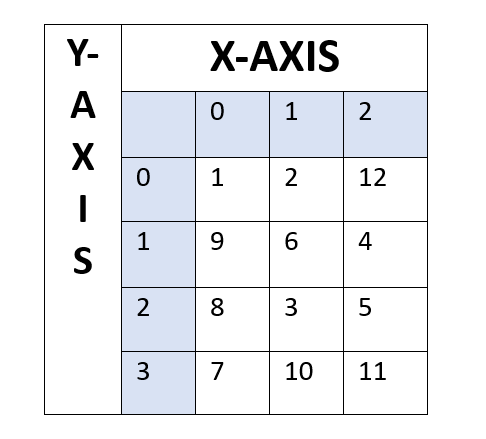
    


  
    def h(self, node):
        """The Manhattan heuristic."""
        X = (0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2)
        Y = (0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3)

        return sum(abs(X[s-1] - X[g-1]) + abs(Y[s-1] - Y[g-1])
                   for (s, g) in zip(node.state, self.goal) if s != 0)
        

---


    The 'hamming_distance' function calculates the Hamming distance between two
    vectors 'A' and 'B', which represents the number of positions where these vectors
    differ.
    - Input: 'A' and 'B' are two vectors (lists or tuples) of equal length.
    - Output: The function returns the number of positions at which 'A' and 'B'
    have different values.
    
    The Hamming distance is a measure of dissimilarity between two vectors and
    is used to count the number of differing elements.
  
    def hamming_distance(A, B):
       "Number of positions where vectors A and B are different."
       return sum(a != b for a, b in zip(A, B))


In [56]:
# Some specific StarPuzzle problems
# Goal: (1,2,12,9,6,4,8,3,5,7,10,11)

e1 = StarPuzzle((1,2,12,9,6,4,0,3,5,0,10,11)) # 2 emty values
e2 = StarPuzzle((1,2,0,9,6,4,0,3,5,0,10,11))  # 3 empty values
e3 = StarPuzzle((1,2,12,9,6,0,8,3,0,0,0,0))   # 5 empty values
e4 = StarPuzzle((0,0,0,9,6,0,8,3,0,0,0,0))    # 8 empty values


In [57]:
# Solve an  Starpuzzle problem and print out each state using Bfs
for s in path_states(breadth_first_search(e1)):
    board_12(s)

25 26 18 33 33 26
32 26 25 33 33 26
33 26 26 33 33 26
32 34 33 33 33 34
33 33 33 33 33 33
       /1\    
    --------  
  \2/12\9/6\4/  
   ------------  
  \0/3\5/0\10/  
   ------------  
       \11/  


       /1\    
    --------  
  \2/12\9/6\4/  
   ------------  
  \8/3\5/0\10/  
   ------------  
       \11/  


       /1\    
    --------  
  \2/12\9/6\4/  
   ------------  
  \8/3\5/7\10/  
   ------------  
       \11/  




In [58]:
# Solve an  Starpuzzle problem and print out each state using Bfs
for s in path_states(breadth_first_search(e2)):
    board_12(s)

13 26 18 21 21 26
20 26 18 28 28 26
21 26 18 29 29 26
25 26 18 33 33 26
28 26 26 28 28 26
32 26 30 28 28 26
28 26 25 29 29 26
33 26 30 29 29 26
32 26 25 33 33 26
33 26 26 33 33 26
28 38 38 28 28 38
32 34 38 28 28 34
28 38 37 29 29 38
33 33 37 29 29 33
32 34 33 33 33 34
33 33 33 33 33 33
       /1\    
    --------  
  \2/0\9/6\4/  
   ------------  
  \0/3\5/0\10/  
   ------------  
       \11/  


       /1\    
    --------  
  \2/12\9/6\4/  
   ------------  
  \0/3\5/0\10/  
   ------------  
       \11/  


       /1\    
    --------  
  \2/12\9/6\4/  
   ------------  
  \8/3\5/0\10/  
   ------------  
       \11/  


       /1\    
    --------  
  \2/12\9/6\4/  
   ------------  
  \8/3\5/7\10/  
   ------------  
       \11/  




In [59]:
# Solve an  Starpuzzle problem and print out each state using Bfs
for s in path_states(breadth_first_search(e3)):
    board_12(s)

33 16 11 29 17 6
33 16 11 33 17 10
33 16 11 34 17 11
33 16 11 36 17 13
33 16 11 39 17 16
33 16 11 40 17 17
33 16 16 33 22 15
33 16 18 33 24 17
33 16 21 33 27 20
33 16 22 33 28 21
33 16 15 34 21 15
33 16 18 34 24 18
33 16 21 34 27 21
33 16 22 34 28 22
33 16 15 36 21 17
33 16 16 36 22 18
33 16 21 36 27 23
33 16 22 36 28 24
33 16 15 39 21 20
33 16 16 39 22 21
33 16 18 39 24 23
33 16 22 39 28 27
33 16 15 40 21 21
33 16 16 40 22 22
33 16 18 40 24 24
33 16 21 40 27 27
33 23 23 33 22 22
33 26 26 33 22 25
33 27 27 33 22 26
33 21 23 33 24 22
33 26 28 33 24 27
33 27 29 33 24 28
33 21 26 33 27 25
33 23 28 33 27 27
33 27 32 33 27 31
33 21 27 33 28 26
33 23 29 33 28 28
33 26 32 33 28 31
33 23 22 34 21 22
33 26 25 34 21 25
33 27 26 34 21 26
33 20 22 34 24 22
33 26 28 34 24 28
33 27 29 34 24 29
33 20 25 34 27 25
33 23 28 34 27 28
33 27 32 34 27 32
33 20 26 34 28 26
33 23 29 34 28 29
33 26 32 34 28 32
33 21 20 36 21 22
33 26 25 36 21 27
33 27 26 36 21 28
33 20 20 36 22 22
33 26 26 36 22 28
33 27 27 36

In [60]:
# Solve an  Starpuzzle problem and print out each state using Bfs
for s in path_states(breadth_first_search(e4)):
    board_12(s)

Streaming output truncated to the last 5000 lines.
33 44 33 22 11 25
33 48 37 22 11 25
33 45 34 22 11 26
33 48 37 22 11 26
33 42 33 22 13 22
33 43 34 22 13 22
33 42 33 22 13 27
33 48 39 22 13 27
33 43 34 22 13 28
33 48 39 22 13 28
33 39 33 22 16 25
33 43 37 22 16 25
33 39 33 22 16 27
33 45 39 22 16 27
33 43 37 22 16 31
33 45 39 22 16 31
33 39 34 22 17 26
33 42 37 22 17 26
33 39 34 22 17 28
33 44 39 22 17 28
33 42 37 22 17 31
33 44 39 22 17 31
33 44 32 23 10 22
33 45 33 23 10 22
33 44 32 23 10 25
33 48 36 23 10 25
33 45 33 23 10 26
33 48 36 23 10 26
33 41 32 23 13 22
33 42 33 23 13 22
33 41 32 23 13 28
33 48 39 23 13 28
33 42 33 23 13 29
33 48 39 23 13 29
33 38 32 23 16 25
33 42 36 23 16 25
33 38 32 23 16 28
33 45 39 23 16 28
33 42 36 23 16 32
33 45 39 23 16 32
33 38 33 23 17 26
33 41 36 23 17 26
33 38 33 23 17 29
33 44 39 23 17 29
33 41 36 23 17 32
33 44 39 23 17 32
33 42 30 25 10 22
33 43 31 25 10 22
33 42 30 25 10 27
33 48 36 25 10 27
33 43 31 25 10 28
33 48 36 25 10 28
33 41 30 25 1

In [61]:
# Solve an  Starpuzzle problem and print out each state using A* search
for s in path_states(astar_search(e1)):
   board_12(s)

25 26 18 33 33 26
33 26 26 33 33 26
32 26 25 33 33 26
33 33 33 33 33 33
       /1\    
    --------  
  \2/12\9/6\4/  
   ------------  
  \0/3\5/0\10/  
   ------------  
       \11/  


       /1\    
    --------  
  \2/12\9/6\4/  
   ------------  
  \8/3\5/0\10/  
   ------------  
       \11/  


       /1\    
    --------  
  \2/12\9/6\4/  
   ------------  
  \8/3\5/7\10/  
   ------------  
       \11/  




In [62]:
# Solve an  Starpuzzle problem and print out each state using A* search
for s in path_states(astar_search(e2)):
   board_12(s)

13 26 18 21 21 26
25 26 18 33 33 26
33 26 26 33 33 26
21 26 18 29 29 26
32 26 25 33 33 26
33 33 33 33 33 33
       /1\    
    --------  
  \2/0\9/6\4/  
   ------------  
  \0/3\5/0\10/  
   ------------  
       \11/  


       /1\    
    --------  
  \2/12\9/6\4/  
   ------------  
  \0/3\5/0\10/  
   ------------  
       \11/  


       /1\    
    --------  
  \2/12\9/6\4/  
   ------------  
  \8/3\5/0\10/  
   ------------  
       \11/  


       /1\    
    --------  
  \2/12\9/6\4/  
   ------------  
  \8/3\5/7\10/  
   ------------  
       \11/  




In [63]:
# Solve an  Starpuzzle problem and print out each state using A* search
for s in path_states(astar_search(e3)):
   board_12(s)

33 16 11 29 17 6
33 16 11 33 17 10
33 16 11 36 17 13
33 16 11 34 17 11
33 16 16 33 22 15
33 16 11 39 17 16
33 16 16 36 22 18
33 23 23 33 22 22
33 16 11 40 17 17
33 16 18 33 24 17
33 16 22 33 28 21
33 16 15 34 21 15
33 16 15 36 21 17
33 16 16 39 22 21
33 26 26 33 22 25
33 33 33 33 22 22
33 16 21 33 27 20
33 16 18 34 24 18
33 16 16 40 22 22
33 16 22 36 28 24
33 16 22 34 28 22
33 16 15 39 21 20
33 23 29 33 28 28
33 23 22 34 21 22
33 27 27 33 22 26
33 26 26 36 22 28
33 20 20 36 22 22
33 23 23 39 22 28
33 34 34 33 22 22
33 33 33 33 33 33
       /1\    
    --------  
  \2/12\9/6\0/  
   ------------  
  \8/3\0/0\0/  
   ------------  
       \0/  


       /1\    
    --------  
  \2/12\9/6\4/  
   ------------  
  \8/3\0/0\0/  
   ------------  
       \0/  


       /1\    
    --------  
  \2/12\9/6\4/  
   ------------  
  \8/3\5/0\0/  
   ------------  
       \0/  


       /1\    
    --------  
  \2/12\9/6\4/  
   ------------  
  \8/3\5/7\0/  
   ------------  
       \0/  


     

In [64]:
# Solve an  Starpuzzle problem and print out each state using A* search
for s in path_states(astar_search(e4)):
   board_12(s)

20 15 11 15 3 6
21 16 11 15 3 6
24 19 11 15 3 6
22 17 11 15 3 6
21 16 11 17 5 6
27 22 11 15 3 6
25 20 11 15 3 6
24 19 11 17 5 6
21 16 11 20 8 6
33 16 11 29 17 6
30 25 11 15 3 6
22 17 11 20 8 6
24 19 11 16 4 6
22 17 11 16 4 6
21 16 11 19 7 6
25 20 11 17 5 6
24 19 11 20 8 6
27 22 11 17 5 6
32 16 11 28 16 6
36 19 11 29 17 6
33 16 11 32 20 6
33 16 11 33 17 10
31 26 11 15 3 6
27 22 11 16 4 6
30 25 11 17 5 6
21 16 11 26 14 6
21 16 11 22 10 6
22 17 11 19 7 6
25 20 11 16 4 6
27 22 11 20 8 6
31 16 11 27 15 6
32 16 11 31 19 6
39 22 11 29 17 6
35 19 11 28 16 6
36 19 11 32 20 6
37 20 11 29 17 6
33 16 11 31 19 6
34 17 11 28 16 6
36 19 11 28 16 6
34 17 11 32 20 6
33 16 11 34 17 11
33 16 11 36 17 13
33 16 11 36 20 10
32 16 11 32 16 10
33 16 16 33 22 15
32 27 11 15 3 6
30 25 11 20 8 6
30 25 11 16 4 6
31 26 11 17 5 6
22 17 11 26 14 6
21 16 11 25 13 6
22 17 11 22 10 6
25 20 11 19 7 6
24 19 11 26 14 6
24 19 11 22 10 6
27 22 11 19 7 6
21 16 11 27 15 6
39 22 11 28 16 6
28 16 11 24 12 6
26 16 11 22 10 6
34 

# **Reporting Summary Statistics on Search Algorithms**

In [67]:
report([breadth_first_search, astar_search],
       [e1])

breadth_first_search:
25 26 18 33 33 26
32 26 25 33 33 26
33 26 26 33 33 26
32 34 33 33 33 34
33 33 33 33 33 33
        4 nodes |        5 goal |    2 cost |       5 actions | StarPuzzle((1, 2, 12, 9, 6, 4, 0, 3, 5, 
        4 nodes |        5 goal |    2 cost |       5 actions | TOTAL

astar_search:
25 26 18 33 33 26
33 26 26 33 33 26
32 26 25 33 33 26
33 33 33 33 33 33
        4 nodes |        4 goal |    2 cost |       5 actions | StarPuzzle((1, 2, 12, 9, 6, 4, 0, 3, 5, 
        4 nodes |        4 goal |    2 cost |       5 actions | TOTAL



In [68]:
report([breadth_first_search, astar_search],
       [e2])

breadth_first_search:
13 26 18 21 21 26
20 26 18 28 28 26
21 26 18 29 29 26
25 26 18 33 33 26
28 26 26 28 28 26
32 26 30 28 28 26
28 26 25 29 29 26
33 26 30 29 29 26
32 26 25 33 33 26
33 26 26 33 33 26
28 38 38 28 28 38
32 34 38 28 28 34
28 38 37 29 29 38
33 33 37 29 29 33
32 34 33 33 33 34
33 33 33 33 33 33
       15 nodes |       16 goal |    3 cost |      13 actions | StarPuzzle((1, 2, 0, 9, 6, 4, 0, 3, 5, 0
       15 nodes |       16 goal |    3 cost |      13 actions | TOTAL

astar_search:
13 26 18 21 21 26
25 26 18 33 33 26
33 26 26 33 33 26
21 26 18 29 29 26
32 26 25 33 33 26
33 33 33 33 33 33
        9 nodes |        6 goal |    3 cost |       8 actions | StarPuzzle((1, 2, 0, 9, 6, 4, 0, 3, 5, 0
        9 nodes |        6 goal |    3 cost |       8 actions | TOTAL



In [69]:
report([breadth_first_search, astar_search],
       [e3])

breadth_first_search:
33 16 11 29 17 6
33 16 11 33 17 10
33 16 11 34 17 11
33 16 11 36 17 13
33 16 11 39 17 16
33 16 11 40 17 17
33 16 16 33 22 15
33 16 18 33 24 17
33 16 21 33 27 20
33 16 22 33 28 21
33 16 15 34 21 15
33 16 18 34 24 18
33 16 21 34 27 21
33 16 22 34 28 22
33 16 15 36 21 17
33 16 16 36 22 18
33 16 21 36 27 23
33 16 22 36 28 24
33 16 15 39 21 20
33 16 16 39 22 21
33 16 18 39 24 23
33 16 22 39 28 27
33 16 15 40 21 21
33 16 16 40 22 22
33 16 18 40 24 24
33 16 21 40 27 27
33 23 23 33 22 22
33 26 26 33 22 25
33 27 27 33 22 26
33 21 23 33 24 22
33 26 28 33 24 27
33 27 29 33 24 28
33 21 26 33 27 25
33 23 28 33 27 27
33 27 32 33 27 31
33 21 27 33 28 26
33 23 29 33 28 28
33 26 32 33 28 31
33 23 22 34 21 22
33 26 25 34 21 25
33 27 26 34 21 26
33 20 22 34 24 22
33 26 28 34 24 28
33 27 29 34 24 29
33 20 25 34 27 25
33 23 28 34 27 28
33 27 32 34 27 32
33 20 26 34 28 26
33 23 29 34 28 29
33 26 32 34 28 32
33 21 20 36 21 22
33 26 25 36 21 27
33 27 26 36 21 28
33 20 20 36 22 22
33 26 2

In [70]:
report([breadth_first_search, astar_search],
       [e4])

Streaming output truncated to the last 5000 lines.
37 38 33 23 21 25
37 44 39 23 21 25
37 41 36 23 21 28
37 44 39 23 21 28
37 44 29 26 11 18
37 45 30 26 11 18
37 44 29 26 11 21
37 48 33 26 11 21
37 45 30 26 11 22
37 48 33 26 11 22
37 38 29 26 17 18
37 39 30 26 17 18
37 38 29 26 17 27
37 48 39 26 17 27
37 39 30 26 17 28
37 48 39 26 17 28
37 35 29 26 20 21
37 39 33 26 20 21
37 35 29 26 20 27
37 45 39 26 20 27
37 39 33 26 20 31
37 45 39 26 20 31
37 35 30 26 21 22
37 38 33 26 21 22
37 35 30 26 21 28
37 44 39 26 21 28
37 38 33 26 21 31
37 44 39 26 21 31
37 41 26 29 11 18
37 42 27 29 11 18
37 41 26 29 11 24
37 48 33 29 11 24
37 42 27 29 11 25
37 48 33 29 11 25
37 38 26 29 14 18
37 39 27 29 14 18
37 38 26 29 14 27
37 48 36 29 14 27
37 39 27 29 14 28
37 48 36 29 14 28
37 32 26 29 20 24
37 39 33 29 20 24
37 32 26 29 20 27
37 42 36 29 20 27
37 39 33 29 20 34
37 42 36 29 20 34
37 32 27 29 21 25
37 38 33 29 21 25
37 32 27 29 21 28
37 41 36 29 21 28
37 38 33 29 21 34
37 41 36 29 21 34
37 38 23 32 1

**The summary of the statistics reported are :**



| **Breadth-First Search (BFS)** | Nodes Expanded | Goal States Reached | Solution Cost | Actions Taken |
|--------------------------------|----------------|---------------------|---------------|---------------|
| e1                     | 4              | 5                   | 2             | 5             |
| e2                     | 15             | 16                  | 3             | 13            |
| e3                     | 206            | 207                 | 5             | 92            |
| e4                     | 69,881         | 69,882              | 8             | 29,570        |



---



| **A* Search (astar_search)**    | Nodes Expanded | Goal States Reached | Solution Cost | Actions Taken |
|---------------------------------|----------------|---------------------|---------------|---------------|
| e1                      | 4              | 5                   | 2             | 5             |
| e2                      | 9              | 6                   | 3             | 8             |
| e3                     | 82             | 30                  | 5             | 34            |
| e4                      | 1,459          | 332                 | 8             | 339           |







**From the tables above it can be proved that :**

- A* Search consistently outperforms BFS in terms of the number of nodes expanded. This demonstrates the efficiency of A* Search in exploring fewer nodes to reach the goal state.

- A* Search also reaches the goal state more efficiently with fewer actions, indicating that it finds optimal solutions more often compared to BFS.

- The 'h' method, referring to the heuristic used in A* Search, plays a crucial role in reducing the number of nodes explored. By including heuristic information, A* Search can focus its exploration on more related and focused paths, which results in a more efficient search process.

In summary, the comparison between BFS and A* Search clearly shows the advantages of using A* Search, especially when combined with the heuristic ('h' method). A* Search explores fewer nodes and often finds optimal solutions more efficiently when it comes to problem solving tasks.